# Project 1 - Air Resistance in a 2D Projectile
## M. Molter

So far, we've completed three guided activities focused on applying the Euler Method to numerical modeling problems. In Project 1, I will be applying the skills gained in the previous exercises to modeling the trajectory of a AP Mark 8 shell fired from a 16" naval canon.

Not much has changed in my programming style; however, I am not including hyperlinks to [relevant documentation](https://docs.python.org/3/) in the notes for your grading convenience.

Let's get started!

Start by importing [`numpy`](http://www.numpy.org/) for numerical computations and [`matplotlib`](https://matplotlib.org/) for plotting. That should be all we need for now.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Now we need to model our system in terms of forces acting on the projectile. Gravity is the simplest force:

$$ F_g = -mg $$

In [2]:
def gravitational_force(m, g=9.80665, dimensions=2, vertical_axis=1):
    ''' Return gravitational force on a projectile subject to gravity.
        
        Returns downward force vector in netwons. 

                  F_g = g * m  

        Args:
            
            m (np.array):           mass of the object (kg) 
            g (np.float64):         gravitational acceleration (m/s**2)
            dimensions (int):       number of dimensions in return vector
            vertical_axis (int):    axis which gravitional force acts on

        Returns:

            (np.array):             gravitational force vector (N)
    '''

    force = np.zeros(dimensions)
    force[vertical_axis] = -g * m
    
    return force

Drag force is a little more complex, it involves calculation of air resistance.

$$
    F_d = \frac{D \rho A}{2} |v|^2
$$

We will need to be able to calculated the magnitude of a multi-dimensional velocity vector, so we should create a quite helper function.

In [3]:
def magnitude(x):
    ''' Return mangitude of vector x. 

        Args:

            x (np.array):   input vector

        Returns
            
            (np.float64):   magnitude of x 
    '''

    return np.sqrt(np.sum(x * x))

The drag force is orientated in the opposite direction of the velocity vector. The easiest way to handle this geometrically is using unit vectors, hence another helper function.

In [4]:
def unit_vector(x):
    ''' Return unit vector for vector x. 

        Args:

            x (np.array):   input vector

        Returns
            
            (np.array):     unit vector for x
    '''

    return x / magnitude(x)

Now we can use these two tools to finally build our drag force function.

In [5]:
def drag_force(v, D, rho, A):
    ''' Return drag force on a projectile subject to air resistance.
        
        Returns a force vector in the opposite direction as the velocity
        vector with a magnitude determined by the drag equation below.

                    F_d = (D * rho * A) / 2 * v**2

        Args:
            
            v (np.array):       velocity vector 
            D (np.float64):     drag coefficient
            rho (np.float64):   air density (units)
            A (np.float64):     cross-sectional area (m**2)

        Returns:

            (np.array):         drag force vector 
    '''

    F_d = ((D * rho * A) / 2) * magnitude(v)**2
    
    return F_d * (-1) * unit_vector(v)

Acceleration of the projectile follows Newtons Law:

$$
    \sum F_i = ma
$$

We have already accounted for our major forces (i.e. gravity and drag), so now we just build them into a function.

In [6]:
def acceleration(x, v, A=1, D=0.5, rho=1.2, m=1225, density_correction=False, vertical_axis=1):
    ''' Return the acceleration vector for a projectile subject to 
        air resistance.
        
        Uses:

                        a = F_net / m

        Args:
            
            v (np.array):       velocity vector 
            D (np.float64):     drag coefficient
            rho (np.float64):   air density (units)
            A (np.float64):     cross-sectional area (m**2)
            m (np.float64):     mass of the projectile (kg)
            density_correction: allows for air-density correction

        Returns:

            (np.array):         acceleration vector 
    '''

    if density_correction:
        rho = air_density(x[vertical_axis])
    
    F_d = drag_force(v, D, rho, A)
    F_g = gravitational_force(m)

    return (F_d + F_g) / m

Finally, we copy over our Euler Method from GA3. We spent the time then to ensure that the function could handle multi-dimensional input. In this latest version, I built in some convient stopping conditions. The Euler Method will stop the computation once the projectile hits `(x, 0)` if `stop_mode='projectile'`.

The function is noticebly more complex, because we no longer know how large of an array to allocate at the start of the method. This function instead pre--allocates 128 points, and doubles the number of points everytime the algorithm reaches the end of the array.

In [7]:
def euler_method(acceleration, t0=0, tf=None, dt=0.1, x0=0, v0=0, modified=False, 
                 stop_mode='normal', vertical_axis=1, **kwargs):
    ''' Returns t, x, v, and a arrays for Euler Method

    Args:
        acceleration (func):    acceleration function **

        t0 (float):             initial time (s)
        tf (float):             final time (s)
        dt (float):             time step (s)
        
        x0 (np.array):          initial displacement (m)
        v0 (np.array):          initial velocity (m/s)
        
        stop_mode:              'normal'     run from t0 to tf
                                'projectile' run until y=0
                                
        vertical_axis           vertical axis for 'projectile' stop mode.
        
        **kwargs:               any additional parameters required for
                                    acceleration function.

    Returns:
        np.float64 (np.array):  list of times (s)
        np.float64 (np.array):  list positions (m)
        np.float64 (np.array):  list velocities (m/s)
        np.float64 (np.array):  list accelerations (m/s**2)
    '''
    
    # Allocate initial array size.
    n = 128
    t = np.empty(n)
    x = np.empty([n, 2])
    v = np.empty([n, 2])
    a = np.empty([n, 2])
        
    # Set initial conditions.
    t[0] = t0
    x[0] = x0
    v[0] = v0
    a[0] = acceleration(x0, v0, **kwargs)
    
    i = 0
    while True:
        # If array is too small, reallocate
        i += 1
        if i >= n:
            t = np.append(t, np.empty(n))
            x = np.append(x, np.empty([n, 2]), axis=0)
            v = np.append(v, np.empty([n, 2]), axis=0)
            a = np.append(a, np.empty([n, 2]), axis=0)
            
            n *= 2
        
        # Run Euler Method
        a[i] = acceleration(x[i-1], v[i-1], **kwargs)
        
        if modified:
            v[i] = v[i-1] + dt * a[i]
            x[i] = x[i-1] + dt * v[i]
        else:
            x[i] = x[i-1] + dt * v[i-1]
            v[i] = v[i-1] + dt * a[i]
            
        t[i] = t[i-1] + dt
        
        # Evaluate stopping conditions.
        if stop_mode == 'normal':
            if t[i] > tf: 
                break
        elif stop_mode == 'projectile':
            if (t[i] > t0) and x[i,vertical_axis] <= 0: 
                break

    # Truncate unused portion of arrays
    t = t[0:i+1]
    x = x[0:i+1,:]
    v = v[0:i+1,:]
    a = a[0:i+1,:]
            
    return t, x, v, a

We just need one last helper function. The initial velocity of a projectile is often specified as a velocity magnitude and an incline. The most convient form for our calculations is x, y (, and z) velocity components. They are found through some basic trigonometry.

$$ x = v_0 \cos(\phi) $$
$$ y = v_0 \sin(\phi) $$

To make thinigs unnecessarily complex, this function also handles azimuth. I am considering doing these problems in 3-dimensions so I can play with coriolis, ship velocity and bearing, and wind velocity. 

In [8]:
def launch_vector(mag, incline, azimuth=False, radians=False):
    ''' Return v0 vector for given scalar magnitude and incline above the horizon. 

        Args:
            magnitude (float):      magnitude of v0 (m/s)
            incline (float):        angle above horizon (degrees)
            azimuth (float):        angle in plane of horizon (degrees)
            radians (bool):         option for using radian incline

        Returns:
            np.array (np.float64):  vector with launch velocity components
    '''
    
    if not radians:
        incline = incline * (np.pi / 180.0)

        if azimuth:
            azimuth = azimuth * (np.pi / 180.0)
    
    if azimuth:
        z = mag * np.sin(incline)
        h = mag * np.cos(incline)

        x = h * np.cos(azimuth)
        y = h * np.sin(azimuth)

        return np.asarray([x, y, z])

    else:
        x = mag * np.cos(incline)
        y = mag * np.sin(incline)

        return np.asarray([x, y])


## Exercise 1
### 2D Projectile with Air Resistance
#### Requirements

1. Build a computational model of a 2D projectile subject to air resistance.
2. Assume air density and the drag coefficient remain constant.
3. Model inputs must be magnitude and angle of initial velocity.
4. Determine accuracy of model.
5. Determine adequate $\Delta t$ for model.
6. Plot a set of parameters of your choosing.

#### Solution

I'll start by trying out the intial velocity function.

In [9]:
launch_vector(mag=100, incline=12)

array([97.81476007, 20.79116908])

Now lets run the Modified Euler Method. We'll fire a 10 $cm^2$ shell with a drage coefficient of 0.5 at 100 $m/s$ and a $40^\circ$ incline.

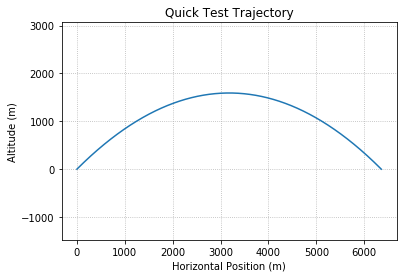

In [22]:
vi = 250 # Initial velocity, (m/s)
inc = 45  # Inline for gun (degrees)
area = 0.01 # Cross sectional area, 10x10 cm.
D = 0.1

dt = 0.001 # s

t, x, v, a =  euler_method(acceleration, 
                           dt=dt, 
                           x0=np.asarray([0,0]), 
                           v0=launch_vector(vi, inc), 
                           modified=True, 
                           stop_mode='projectile', 
                           A=area,
                           D=D)
    
plt.plot(x[:,0], x[:,1])
plt.grid(which='both', linestyle=':')
plt.title('Quick Test Trajectory')
plt.xlabel('Horizontal Position (m)')
plt.ylabel('Altitude (m)')
plt.ylim(ymin=0)
plt.axis('equal')
plt.show()

## Exercise 2
### Shape of the 2D Projectile Trajectory
#### Requirements

1. Compare your model to a parabola, are they the same?

#### Solution

Lets create a quick helper function for plotting parabolas.

In [11]:
def parabola(x, a, b, c):
    ''' Return a parabola given entered in standard form. '''
    
    return a * x**2 + b * x + c

Now we have to find a way to compare the modeled trajectory to that of a parabola. We will use the first few data points from the Euler method (before drag takes a significant effect) to fit the a standard parabola (See [`curve_fit()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)).

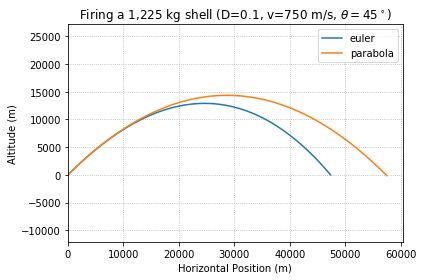

In [12]:
from scipy.optimize import curve_fit

vi = 750 # Initial velocity, (m/s)
inc = 45  # Inline for gun (degrees)
area = 0.10 # Cross sectional area, 10x10 cm.
mass = 1225 # Mass (kg)
D = 0.1

dt = 0.001 # s

t, x, v, a =  euler_method(acceleration, 
                           dt=dt, 
                           x0=np.asarray([0,0]), 
                           v0=launch_vector(vi, inc), 
                           modified=True, 
                           stop_mode='projectile', 
                           A=area,
                           D=D,
                           m=mass)

# Fit parameters a, b, and c (into popt).
popt, pcov = curve_fit(parabola, x[0:10,0], x[0:10,1])

# Plot the Euler Method results.
plt.plot(x[:,0], x[:,1], label='euler')

# Plot the parabola fitted to the first 10 data points.
px = np.linspace(0, 57500, 10000)
plt.plot(px, parabola(px, *popt), label='parabola')

# Setup the graph.
plt.grid(which='both', linestyle=':')
plt.xlabel('Horizontal Position (m)')
plt.ylabel('Altitude (m)')
plt.axis('equal')
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.title(r'Firing a 1,225 kg shell (D=0.1, v=750 m/s, $\theta=45^\circ$)')
plt.legend()
plt.show()

While the parabola models the inital portion of the trajectory well, the real shell falls off far sooner.

# Exercise 3
### Angle for Maximum Projectile Range
#### Requirements

1. What angles of $\theta$ ($\pm 0.1^\circ$) maximize the range? Use three very differnt drag coefficients.
2. Plot all three trajectories together. Label max range, angle, and drag coefficient for each series.


#### Solution

Let's start by building a `find_range()` function that takes an initial velocity, area, drag coeffient, etc. and simply returns the maximum horizontal range.

In [13]:
def find_range(v0, area=0.1, D=0.3, dt=0.01, **kwargs):
    ''' Returns the horizonal range for a given set of firing conditions. 
    
        Args:
        
            v0 (np.array):      inital velocity components (m/s)
            area (np.float64):  cross-sectional area (m**2)
            D (np.float64):     drag coefficient
            dt (np.float64):    simulation timestep
            **kwargs:           other simulation keyword paramters
    
    '''
    t, x, v, a =  euler_method(acceleration, 
                           dt=dt, 
                           x0=np.asarray([0,0]), 
                           v0=v0, 
                           modified=True, 
                           stop_mode='projectile', 
                           A=area,
                           D=D,
                           **kwargs)
    
    return max(x[:, 0])

find_range(launch_vector(750, 12))

19124.98474211602

Now lets take advantage of the scipy optimization functions to find the angle, $\theta$, that maximizes the range subject to the constraint $0\le\theta\le90^\circ$.

We are trying to "maximize" range, but SciPy only supports minimization ([`minimize_scalar()`](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.optimize.minimize_scalar.html)). In practice, these are the same thing, and we can write a lambda function such that:

$$\max \left(f(x)\right) = \min \left(-f(x)\right)$$

Let's try out the minimization, so it's clear how it works.

In [14]:
from scipy.optimize import minimize_scalar as minimize

vi = 750 # Initial muzzle velocity (m/s)
D  = 0.3   # Drag coefficient

res = minimize(lambda theta: -1 * find_range(launch_vector(vi, theta), D=D))

max_range = res.fun * -1
max_angle = res.x

print('For a muzzle velocity of {:.2f} m/s,'
      'the maximum range is {:.0f} m at an '
      'incline of {:.2f} degrees'.format(vi, max_range, max_angle))

For a muzzle velocity of 750.00 m/s,the maximum range is 36155 m at an incline of 41.64 degrees


Now lets try a D of 0.1, 0.2, and 0.5:

Drag Coeff:	0.10	Angle:	43.46 (deg)	Range:	47410 m
Drag Coeff:	0.20	Angle:	42.49 (deg)	Range:	40861 m
Drag Coeff:	0.50	Angle:	40.00 (deg)	Range:	29747 m


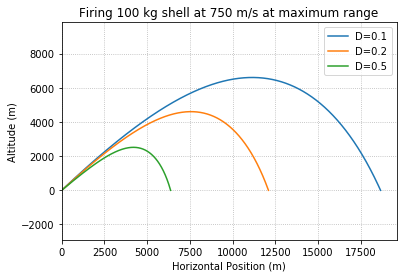

In [15]:
vi = 750 # Initial muzzle velocity (m/s)
area = 0.1 # Shell cross-sectional area (m**2)
mass = 100 # kg

for D in [0.1, 0.2, 0.5]:
    
    # Find the maximum angle.
    res = minimize(lambda t: -1 * find_range(launch_vector(vi, t), D=D, area=area))
    
    max_range = res.fun * -1
    max_angle = res.x 
    
    print('Drag Coeff:\t{:.2f}\tAngle:\t{:.2f} (deg)\tRange:\t{:.0f} m'.format(D, max_angle, max_range))
    
    # Plot the graph of maximum angle.
    t, x, v, a =  euler_method(acceleration, 
                       dt=dt, 
                       x0=np.asarray([0,0]), 
                       v0=launch_vector(vi, max_angle), 
                       modified=True, 
                       stop_mode='projectile', 
                       A=area,
                       D=D,
                       m=mass)
    
    plt.plot(x[:,0], x[:,1], label='D={}'.format(D))
    
# Setup the graph.
plt.grid(which='both', linestyle=':')
plt.xlabel('Horizontal Position (m)')
plt.ylabel('Altitude (m)')
plt.axis('equal')
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.title('Firing 100 kg shell at 750 m/s at maximum range')
plt.legend()
plt.show()

# Exercise 4
### 2D Model with Air Resistance--Naval Gun
#### Requirements

1. Goto http://www.navweaps.com/Weapons/WNUS_1650_mk6.php and retrieve real parameters (i.e. mass, frontal area, initial velocity) for a 16" naval gun.
2. Account for changes in air density.
3. Determine a constant drag coefficient, D, by fiting your model to the following data. Use "new gun" muzzle velocities.


|**Elevation ($^\circ$)**|**AP Mark 8 (m)**|**HC Mark 13 (m)**| 
|:-----:|:-----:|:-----:|
|10|16139|16642| 
|15|21854|22037| 
|20|26518|26335| 
|25|30450|29901| 
|30|33558|32918| 
|35|36119|35342| 
|40|37884|37163| 
|45|38720|38059|     

#### Solution

According to (http://www.navweaps.com/Weapons/WNUS_1650_mk6.php), a 16" Mark 7 naval gun firing a AP Mark 8 shell has the following physical parameters.

|**Measurement**|**Value**|**Unit**|
| :---: | :---: | :---: |
| Muzzle Velocity | 762 | m/s |
| Shell Diameter | 16 | inch |
| Cross-sectional Area | 0.1297 | m$^2$ |
| Shell Mass | 1,225 | kg|

Lets do the easy part next: modeling altitude--dependent air density. Near the Earth (< 10,000 m), air density follows the following relasion:

$$
    \rho(y) = \rho_o \left( 1 - \frac{cy}{T_o} \right)^\alpha
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where,
    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\rho_o=1.2$ is the air density at sea level ($\text{kg}/\text{m}^3$) 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$c=6.5\times10^{-3}$ is the change in temperaure with altitude ($K/m$)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$T_o=300$ is the temperature at sea level ($K$)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\alpha=2.5$ is...I have no idea...

In [16]:
def air_density(y, rho0=1.2, c=6.5e-3, T0=300, alpha=2.5):
    ''' Return altitude dependent air density, rho.

        Derrived from thermodynamic calculations and remains
        a good approximation upt to 10 km (Roos, 2018).

        Uses:

            rho(y) = rho0 (1 - (cy/T0))**alpha

        Args:

            y (float):      altitude (m)
            rho (float):    air density as sea level (kg/m**3)
            c (float):      temperature fall (K/m)
            T0 (float):     temperature at sea level (K)
            alpha (float):  unknown?

        Returns:
            
            (float):        air density at altitude (kg/m**3)
    '''

    return rho0 * (1 - c * y / T0)**alpha

Lets fire a quick plot of that.

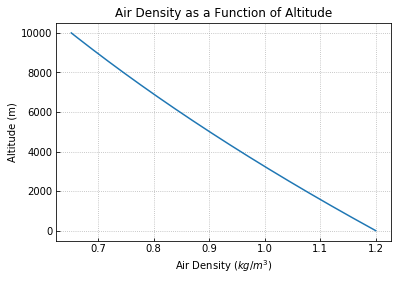

In [17]:
y = np.linspace(0, 10000, 1000)
rho = air_density(y)

plt.plot(rho, y)
plt.title('Air Density as a Function of Altitude')
plt.xlabel('Air Density ($kg/m^3$)')
plt.ylabel('Altitude (m)')

plt.grid(which='both', linestyle=':')
plt.tick_params(which='both', direction='in')

plt.show()

Let's try a trajectory with, and without air density correction (assume $\rho_o = 1.2$).

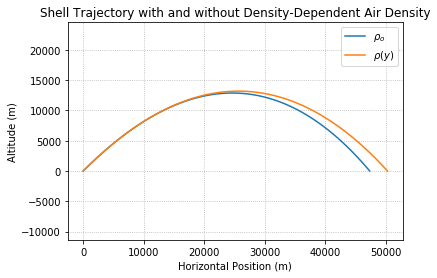

In [21]:
t_simp, x_simp, v_simp, a_simp =  euler_method(acceleration, 
                                               dt=0.01, 
                                               x0=np.asarray([0,0]), 
                                               v0=launch_vector(750, 45), 
                                               modified=True, 
                                               stop_mode='projectile', 
                                               A=0.1,
                                               D=0.1,
                                               rho=1.2)

t_comp, x_comp, v_comp, a_comp =  euler_method(acceleration, 
                                               dt=0.01, 
                                               x0=np.asarray([0,0]), 
                                               v0=launch_vector(750, 45), 
                                               modified=True, 
                                               stop_mode='projectile', 
                                               A=0.1,
                                               D=0.1,
                                               density_correction=True)


    
plt.plot(x_simp[:,0], x_simp[:,1], label=r'$\rho_o$')
plt.plot(x_comp[:,0], x_comp[:,1], label=r'$\rho(y)$')

plt.grid(which='both', linestyle=':')
plt.title('Shell Trajectory with and without Density-Dependent Air Density')
plt.xlabel('Horizontal Position (m)')
plt.ylabel('Altitude (m)')
plt.ylim(ymin=0)
plt.axis('equal')
plt.legend()
plt.show()

The air density correction accounts for the reduced drag on the shell at higher altitudes. At long ranges, this leads to a significant increase in range.

In [19]:
print(find_range(launch_vector(750, 45), area=0.1, D=0.1, density_correction=True))
print(find_range(launch_vector(750, 45), area=0.1, D=0.1, density_correction=False))

50294.865747899246
47350.46825929259


Now lets find a realistic value for the drag coeffient of the AP Mark 8 shell. To my unfortunate surprise, [`curve_fit()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) requires the fitting function to accept `numpy` array [broadcasting](https://docs.scipy.org/doc/numpy-1.14.0/user/basics.broadcasting.html)--my `euler_method()` function definetly doesn't do that. We'll just have to roll our own using `minimize_scalar()` again.

In [24]:
from scipy.optimize import minimize_scalar

# Empirical Data
elevations = [10, 15, 20, 25, 30, 35, 40, 45]
ranges = [16139, 21854, 26518, 30450, 33558, 36119, 37884, 38720]

def sum_of_squares(elv, rng, D):
    ''' Return Sum of Squares (SS) given D for numerical model'''
    
    ss = 0
    for e, r in zip(elv, rng):
        num_range = find_range(launch_vector(762, e), area=0.1297, D=D, m=1225, density_correction=True)
        ss += (num_range - r)**2
        
    return ss
        
res = minimize(lambda D: sum_of_squares(elevations, ranges, D))
real_D = res.x

print('A drag coefficient of {:.3f} most closely models the empirical data.'.format(real_D))

D=0.297 most closely models the empirical data.


Now let's see how well our "optimum" drag coefficent fits the empirical data.

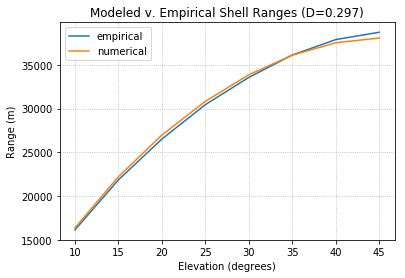

In [26]:
# Empirical Data
elevations = [10, 15, 20, 25, 30, 35, 40, 45]
real_ranges = [16139, 21854, 26518, 30450, 33558, 36119, 37884, 38720]
num_ranges = [find_range(launch_vector(762, e), area=0.1297, D=real_D, m=1225, density_correction=True) for e in elevations]

plt.plot(elevations, real_ranges, label='empirical')
plt.plot(elevations, num_ranges, label='numerical')

plt.grid(linestyle=':')
plt.xlabel('Elevation (degrees)')
plt.ylabel('Range (m)')
plt.title('Modeled v. Empirical Shell Ranges (D=0.297)')
plt.legend()

plt.show()

# Exercise 5
### Angle for Maximum Range
#### Requirements

1. Find the maximum angle for the naval projectile using the accurate parameters from Exercise 4.
2. Is the angle greater or smaller than $45^\circ$